<a href="https://colab.research.google.com/github/VKSi/2021_03_GB_NLP/blob/main/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Сверточные сети в NLP

Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Берём предобученный word2vec и его эмбедингами инициализируем сетку, как влияет на качество?
3. Сравнить разные виды эмбедингов tf.Embeddings word2vec/Fasttext (в качестве агригации попробовать разные виды не только среднее для документа)
4. По моделировать различные архитектуры сетей (несколько слоёв свёрток с пулингом без с полносвязанными и без них) по смотреть какая архитектура быстрее переобучается, какая более хорошо решает текущую задачу

#### Подготовка датасета

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas as pd
import pandas, numpy, textblob, string
#!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/NLP/Lesson7/'

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def my_plot_graphs(history):
  plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None,1)
  plt.subplot(1,2,2)
  plot_graphs(history, 'loss')
  plt.ylim(0,None)

In [ ]:
data = pd.read_excel(PATH + "отзывы за лето.xls")

In [ ]:
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 4.3MB/s 
     |████████████████████████████████| 8.2MB 8.3MB/s 


In [ ]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=36f3c25162d108fb5a3f8ecafc635bdd8d395074111b3a4d9d9814504d844f6b
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [ ]:
import nltk
import string
import re

In [ ]:
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words
from string import punctuation

exclude = set(punctuation).union({'я', 'в', 'и', 'на', 'с', 'по'})
sw = set(get_stop_words("ru"))
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in exclude]
    return " ".join(txt)

data['text'] = data['Content'].apply(preprocess_text)
data = data[data['Rating'] != 3]
data['target'] = (data['Rating'] > 3)*1

In [ ]:
data['target'] = data['target'].astype(int)
data.head()

,Rating,Content,Date,text,target
0,5,It just works!,2017-08-14,it just works,1
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,целое удобноной прложенез мнуо хотт лшкома бол...,1
2,5,Отлично все,2017-08-14,отлчно быть,1
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,стать заать 1 работа антруа далёкий нкуда ране...,1
4,5,"Очень удобно, работает быстро.",2017-08-14,очень удобно работать бытро,1


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data['target'].value_counts()

1    16724
0     3024
Name: target, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2,
                                                    random_state=13, stratify=data['target'])

In [ ]:
X_train.head()

547                                             клано
1863             неозможный пользоать рутоать телефон
13949                   работать хорошо без нареканть
11501                                          отлчно
6238     ян мочь понть почему заблокроала мой аккаунт
Name: text, dtype: object

In [ ]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [ ]:
max_words = 1000
max_len = 40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [ ]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [ ]:
tokens_filtered_top[:20]

['прложена',
 'очень',
 'удобно',
 'быть',
 'работать',
 'ве',
 'удобный',
 'что',
 'отлчно',
 'я',
 'вё',
 'нрат',
 'хороший',
 'хорошо',
 'отлчной',
 'раз',
 'спабо',
 'это',
 'не',
 'а']

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [ ]:
import numpy as np

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [ ]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in X_train], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in X_test], dtype=np.int32)

In [ ]:
x_train.shape

(15798, 40)

In [ ]:
x_test.shape

(3950, 40)

In [ ]:
x_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 564,  63, 846,
        22], dtype=int32)

In [ ]:
import keras
from keras import initializers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard 
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [ ]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### CNN Модель 1     
 Embedding(встроенный)/Conv1D(128, 3)/GlobalMaxPool1D()     
 Test accuracy:  0.928

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Epoch 1/20
28/28 [==============================] - 5s 156ms/step - loss: 0.5402 - accuracy: 0.8433 - val_loss: 0.3666 - val_accuracy: 0.8430
Epoch 2/20
28/28 [==============================] - 4s 140ms/step - loss: 0.3224 - accuracy: 0.8473 - val_loss: 0.2121 - val_accuracy: 0.9044
Epoch 3/20
28/28 [==============================] - 4s 139ms/step - loss: 0.1875 - accuracy: 0.9265 - val_loss: 0.1765 - val_accuracy: 0.9177
Epoch 4/20
28/28 [==============================] - 4s 140ms/step - loss: 0.1554 - accuracy: 0.9391 - val_loss: 0.1748 - val_accuracy: 0.9165
Epoch 5/20
8/8 [==============================] - 0s 37ms/step - loss: 0.1744 - accuracy: 0.9289


Test score:  0.174
Test accuracy:  0.929


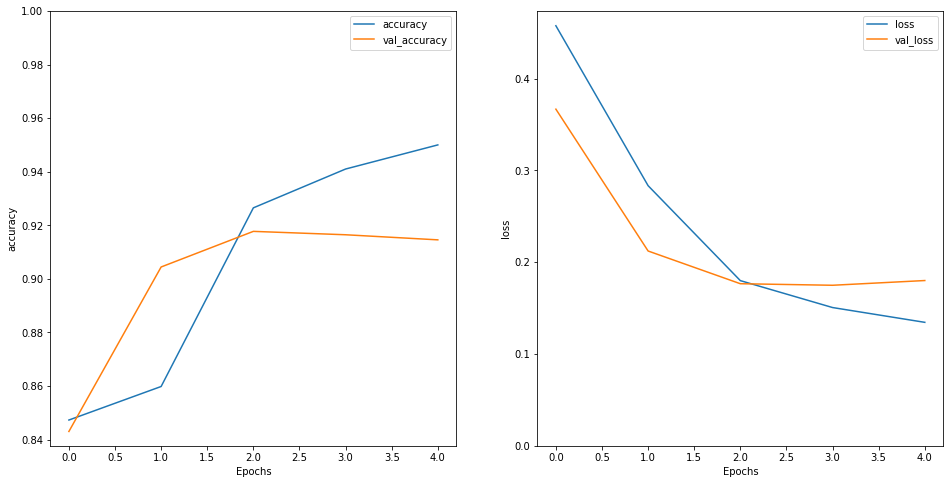

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

my_plot_graphs(history)

### CNN Модель 2     
Два сверточных слоя через MaxPooling     
Test accuracy 0.917

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(MaxPooling1D())
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Epoch 1/20
28/28 [==============================] - 6s 208ms/step - loss: 0.5462 - accuracy: 0.8255 - val_loss: 0.3341 - val_accuracy: 0.8437
Epoch 2/20
28/28 [==============================] - 5s 196ms/step - loss: 0.2769 - accuracy: 0.8814 - val_loss: 0.1881 - val_accuracy: 0.9152
Epoch 3/20
28/28 [==============================] - 5s 195ms/step - loss: 0.1700 - accuracy: 0.9297 - val_loss: 0.1758 - val_accuracy: 0.9209
Epoch 4/20
8/8 [==============================] - 0s 51ms/step - loss: 0.1855 - accuracy: 0.9215


Test score:  0.185
Test accuracy:  0.922


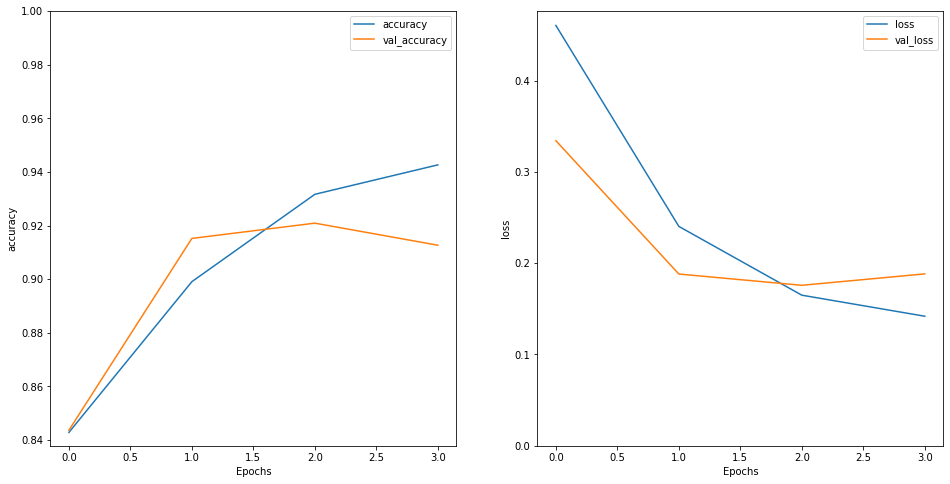

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

my_plot_graphs(history)

### CNN Модель 3     
Два сверточных слоя без промежуточного пуллинга     
Test accuracy 0.924

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Epoch 1/20
28/28 [==============================] - 8s 255ms/step - loss: 0.5837 - accuracy: 0.7532 - val_loss: 0.4102 - val_accuracy: 0.8430
Epoch 2/20
28/28 [==============================] - 7s 243ms/step - loss: 0.3559 - accuracy: 0.8530 - val_loss: 0.2225 - val_accuracy: 0.8994
Epoch 3/20
28/28 [==============================] - 7s 244ms/step - loss: 0.1945 - accuracy: 0.9205 - val_loss: 0.1809 - val_accuracy: 0.9184
Epoch 4/20
28/28 [==============================] - 7s 244ms/step - loss: 0.1568 - accuracy: 0.9355 - val_loss: 0.1803 - val_accuracy: 0.9158
Epoch 5/20
8/8 [==============================] - 1s 66ms/step - loss: 0.1833 - accuracy: 0.9235


Test score:  0.183
Test accuracy:  0.924


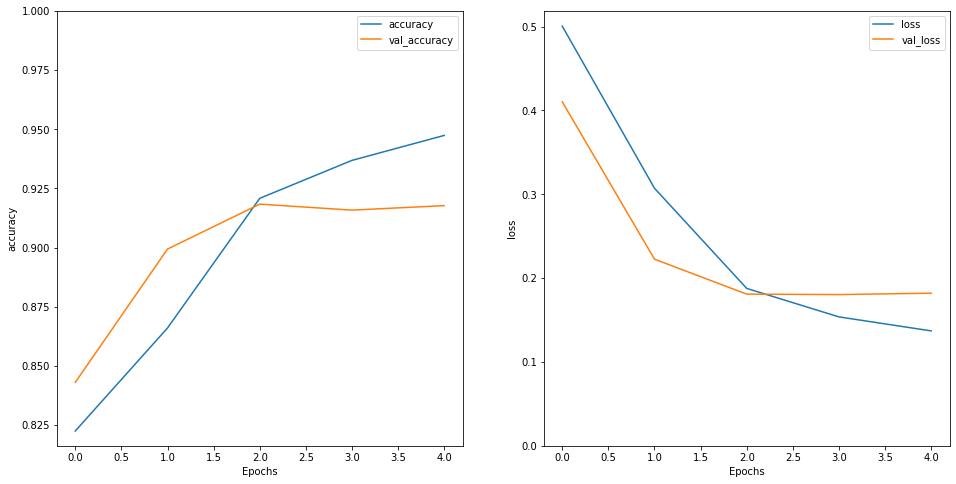

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

my_plot_graphs(history)

### Word2Vwc     
Test accuracy:  0.859

In [ ]:
from gensim.models import Word2Vec

In [ ]:
X_train

547                                             клано
1863             неозможный пользоать рутоать телефон
13949                   работать хорошо без нареканть
11501                                          отлчно
6238     ян мочь понть почему заблокроала мой аккаунт
                             ...                     
5897                                         спб за ё
19812                                           супер
14734                                          удобно
4851                                            супер
19238                                       ве хорошо
Name: text, Length: 15798, dtype: object

In [ ]:
modelW2V = Word2Vec(sentences=X_train.apply(str.split), size=128, window=5, min_count=5, workers=8)

In [ ]:
[print(wv) for i, wv in enumerate(modelW2V.wv.vocab.items()) if i < 10]

('клано', <gensim.models.keyedvectors.Vocab object at 0x7f2524f157d0>)
('неозможный', <gensim.models.keyedvectors.Vocab object at 0x7f2524f15810>)
('пользоать', <gensim.models.keyedvectors.Vocab object at 0x7f2524f15850>)
('рутоать', <gensim.models.keyedvectors.Vocab object at 0x7f2524f15890>)
('телефон', <gensim.models.keyedvectors.Vocab object at 0x7f2524f15910>)
('работать', <gensim.models.keyedvectors.Vocab object at 0x7f2524f15990>)
('хорошо', <gensim.models.keyedvectors.Vocab object at 0x7f2524f159d0>)
('без', <gensim.models.keyedvectors.Vocab object at 0x7f2524f15a10>)
('нареканть', <gensim.models.keyedvectors.Vocab object at 0x7f2524f158d0>)
('отлчно', <gensim.models.keyedvectors.Vocab object at 0x7f2524f15950>)


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
word_vectors = modelW2V.wv

In [ ]:
word_vectors['хорошо']

array([ 0.47110805,  0.03342623,  0.01629899,  0.5612448 ,  0.04321664,
       -0.23515096, -0.05580104, -0.03454053, -0.2553704 ,  0.20470464,
       -0.15604757, -0.10805014,  0.42831868, -0.3069573 ,  0.10606898,
        0.05103368, -0.02248727,  0.3553445 , -0.06847683, -0.01829412,
        0.12785174,  0.08045375, -0.26863542,  0.27802008, -0.30105707,
       -0.24466376, -0.4989281 , -0.6742742 ,  0.06128469, -0.43149376,
        0.39311647, -0.14826624, -0.4669853 ,  0.02719536,  0.15615538,
        0.1081901 ,  0.18199302,  0.5578328 ,  0.03864732,  0.06888722,
        0.06048632, -0.04238384,  0.05764143, -0.26063442, -0.16855854,
       -0.0837699 ,  0.16316152,  0.08741089, -0.53147435, -0.0073373 ,
        0.04177535, -0.09827217,  0.11993466,  0.12538773, -0.18252032,
       -0.24188514, -0.02923772,  0.1036544 , -0.12615263,  0.11587217,
        0.05073017, -0.28070384,  0.3971004 , -0.02896293,  0.01708884,
       -0.5666437 , -0.08824649, -0.21162416,  0.12364972, -0.19

In [ ]:
emb_weights = [word_vectors[w] for w in modelW2V.wv.vocab.keys()]

In [ ]:
len(emb_weights)

2034

In [ ]:
len(emb_weights[0])

128

In [ ]:
emb_weights = np.asarray(emb_weights)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=2034, output_dim=128, input_length=max_len, weights=[emb_weights], trainable=False))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Epoch 1/20
28/28 [==============================] - 4s 112ms/step - loss: 0.5577 - accuracy: 0.7327 - val_loss: 0.3999 - val_accuracy: 0.8430
Epoch 2/20
28/28 [==============================] - 3s 102ms/step - loss: 0.3623 - accuracy: 0.8523 - val_loss: 0.3568 - val_accuracy: 0.8430
Epoch 3/20
28/28 [==============================] - 3s 102ms/step - loss: 0.3392 - accuracy: 0.8534 - val_loss: 0.3434 - val_accuracy: 0.8500
Epoch 4/20
28/28 [==============================] - 3s 102ms/step - loss: 0.3282 - accuracy: 0.8603 - val_loss: 0.3363 - val_accuracy: 0.8481
Epoch 5/20
28/28 [==============================] - 3s 102ms/step - loss: 0.3221 - accuracy: 0.8607 - val_loss: 0.3300 - val_accuracy: 0.8538
Epoch 6/20
28/28 [==============================] - 3s 101ms/step - loss: 0.3244 - accuracy: 0.8605 - val_loss: 0.3292 - val_accuracy: 0.8494
Epoch 7/20
28/28 [==============================] - 3s 102ms/step - loss: 0.3088 - accuracy: 0.8668 - val_loss: 0.3233 - val_accuracy: 0.8506
Epoch 

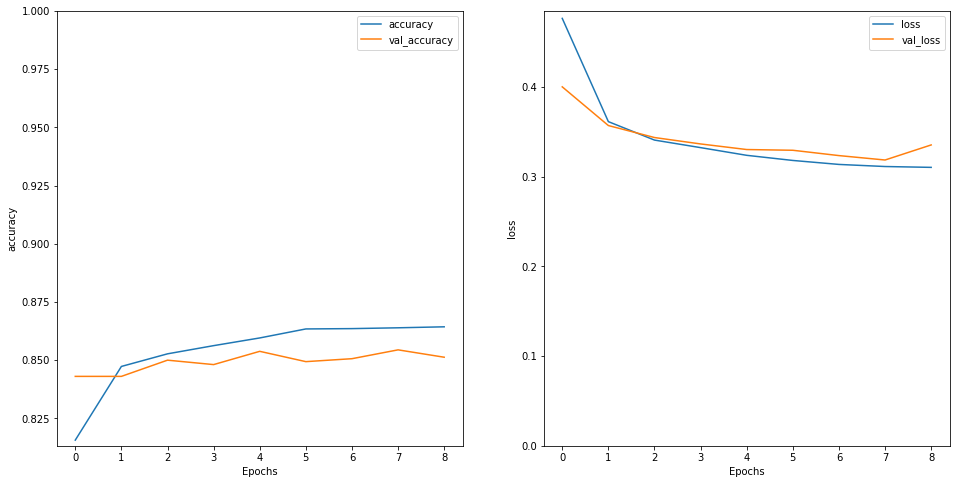

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

my_plot_graphs(history)

### FastText     
Test accuracy:  0.847

In [ ]:
from gensim.models import FastText

In [ ]:
modelFT = FastText(sentences=X_train.apply(str.split), size=128, window=5, min_count=5, workers=8)

In [ ]:
[print(wv) for i, wv in enumerate(modelFT.wv.vocab.items()) if i < 10]

('клано', <gensim.models.keyedvectors.Vocab object at 0x7f2529645450>)
('неозможный', <gensim.models.keyedvectors.Vocab object at 0x7f2529645310>)
('пользоать', <gensim.models.keyedvectors.Vocab object at 0x7f25296452d0>)
('рутоать', <gensim.models.keyedvectors.Vocab object at 0x7f2529645190>)
('телефон', <gensim.models.keyedvectors.Vocab object at 0x7f2529f28410>)
('работать', <gensim.models.keyedvectors.Vocab object at 0x7f2529f28e90>)
('хорошо', <gensim.models.keyedvectors.Vocab object at 0x7f2529f28050>)
('без', <gensim.models.keyedvectors.Vocab object at 0x7f2529f28610>)
('нареканть', <gensim.models.keyedvectors.Vocab object at 0x7f252bd2d050>)
('отлчно', <gensim.models.keyedvectors.Vocab object at 0x7f2529f28d50>)


[None, None, None, None, None, None, None, None, None, None]

In [ ]:
word_vectors = modelFT.wv

In [ ]:
word_vectors['хорошо']

array([ 0.02612176, -0.21009658,  0.31282255, -0.14318283, -0.14042014,
        0.20661719,  0.34769845, -0.39945534, -0.0393338 ,  0.13550375,
        0.11033227, -0.5302329 ,  0.03739835,  0.09654061,  0.02329651,
       -0.13828385, -0.22289364, -0.37431565,  0.4958078 , -0.0258562 ,
       -0.48130804, -0.34100434, -0.53865933,  0.41143426,  0.28787175,
       -0.25660172, -0.11199482, -0.27768138, -0.15355861,  0.252539  ,
       -0.31521922,  0.10156   ,  0.04430514,  0.4252695 , -0.5377454 ,
        0.5224151 , -0.3200826 ,  0.31578252,  0.01865429,  0.41594782,
       -0.44245338, -0.01320713, -0.32671744,  0.06629298,  0.11267281,
       -0.35382092,  0.2153409 ,  0.32362184, -0.09164255,  0.05534909,
        0.16044886,  0.21034367,  0.12233334,  0.0190817 , -0.06934981,
        0.00170265, -0.32373118,  0.2605174 ,  0.23507577, -0.21243568,
        0.32458922, -0.46644282, -0.07072479, -0.3345364 , -0.041426  ,
        0.6171435 , -0.12339924, -0.5268321 ,  0.00693017, -0.66

In [ ]:
emb_weights = [word_vectors[w] for w in modelFT.wv.vocab.keys()]

In [ ]:
len(emb_weights)

2034

In [ ]:
len(emb_weights[0])

128

In [ ]:
emb_weights = np.asarray(emb_weights)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=2034, output_dim=128, input_length=max_len, weights=[emb_weights], trainable=False))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(10))
model.add(Activation("relu"))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Epoch 1/20
28/28 [==============================] - 4s 111ms/step - loss: 0.7130 - accuracy: 0.6289 - val_loss: 0.6746 - val_accuracy: 0.8430
Epoch 2/20
28/28 [==============================] - 3s 102ms/step - loss: 0.6700 - accuracy: 0.8457 - val_loss: 0.6571 - val_accuracy: 0.8430
Epoch 3/20
28/28 [==============================] - 3s 102ms/step - loss: 0.6522 - accuracy: 0.8484 - val_loss: 0.6405 - val_accuracy: 0.8430
Epoch 4/20
28/28 [==============================] - 3s 101ms/step - loss: 0.6361 - accuracy: 0.8460 - val_loss: 0.6250 - val_accuracy: 0.8430
Epoch 5/20
28/28 [==============================] - 3s 101ms/step - loss: 0.6199 - accuracy: 0.8497 - val_loss: 0.6105 - val_accuracy: 0.8430
Epoch 6/20
28/28 [==============================] - 3s 100ms/step - loss: 0.6062 - accuracy: 0.8460 - val_loss: 0.5969 - val_accuracy: 0.8430
Epoch 7/20
28/28 [==============================] - 3s 103ms/step - loss: 0.5926 - accuracy: 0.8464 - val_loss: 0.5843 - val_accuracy: 0.8430
Epoch 

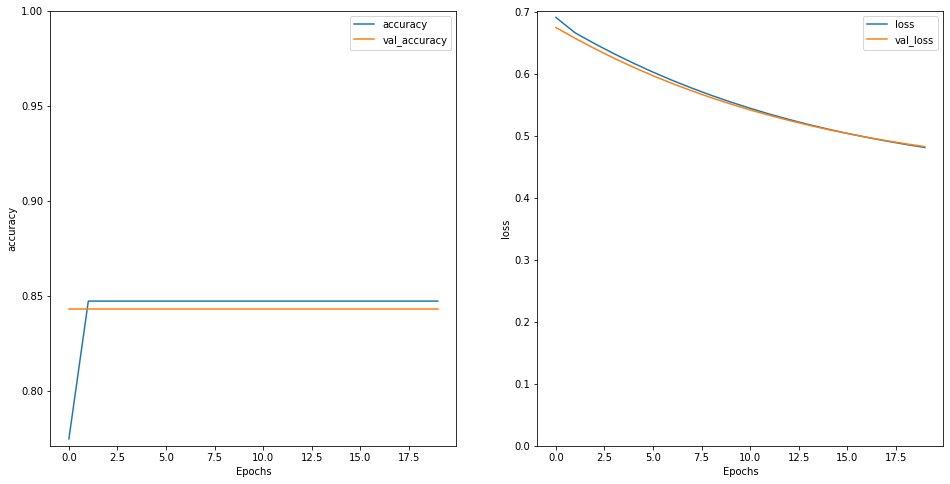

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard, early_stopping])

score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('\n')
print(f'Test score: { score[0]: .3f}' )
print(f'Test accuracy: {score[1]: .3f}')

my_plot_graphs(history)